# Performance analysis

Importing libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Comparing expected sequential execution time with the actual execution time:

In [2]:
default_seq_data = pd.read_csv('results/wavefront_seq_log.csv', header=None)
default_seq_data.columns = ['N', 'T', 'min', 'max', "es_time", "as_time", "pd_time", "ps_time"]
default_seq_data[['es_time', 'as_time']]

,es_time,as_time
0,65,65.5473
1,65,65.5472
2,65,65.5471
3,65,65.5471
4,65,65.5473
5,65,65.5473
6,65,65.5473
7,65,65.5475
8,65,65.5474
9,65,65.5471


Defining constants:

In [3]:
MACHINE_TAG = "cluster" # or "numa"
LOGFILE = f"results/{MACHINE_TAG}_wavefront_log.csv"
MACHINE = f"spm{MACHINE_TAG}.unipi.it"
NUM_CORES = 40 if MACHINE_TAG == "cluster" else 60
DEFAULT_N = 512
DEFAULT_MIN = 0
DEFAULT_MAX = 1000

Loading the data:

In [4]:
data = pd.read_csv(LOGFILE, header=None)
data.columns = [
    "N", "T", "min", "max",
    "es_time", "as_time",
    "pd_time", "ps_time"
]
data

,N,T,min,max,es_time,as_time,pd_time,ps_time
0,512,1,0,1000,65,-1,65.71040,65.57850
1,512,1,0,1000,65,-1,65.68980,65.56160
2,512,1,0,1000,65,-1,65.69290,65.56450
3,512,1,0,1000,65,-1,65.69300,65.56240
4,512,1,0,1000,65,-1,65.69310,65.56300
...,...,...,...,...,...,...,...,...
245,512,40,500,500,65,-1,1.82504,1.84133
246,512,40,500,500,65,-1,1.82017,1.84401
247,512,40,500,500,65,-1,1.82859,1.83984
248,512,40,500,500,65,-1,1.82574,1.81534


Filtering minimum and maximum execution times and computing the mean time:

In [5]:
def filter_min_max(group):
    max_t1_idx = group['pd_time'].idxmax()
    max_t2_idx = group['ps_time'].idxmax()
    min_t1_idx = group['pd_time'].idxmin()
    min_t2_idx = group['ps_time'].idxmin()
    return group.drop([max_t1_idx, max_t2_idx, min_t1_idx, min_t2_idx])

data_grouped = data.groupby(["T", "N", "min", "max"]).apply(
    filter_min_max,
    include_groups=False
)
data_grouped = data_grouped.reset_index().drop(columns="level_4")
data_grouped = data_grouped.groupby(["T", "N", "min", "max"]).agg(["mean"])
data_grouped

es_time as_time     pd_time     ps_time
                      mean    mean        mean        mean
T  N   min   max                                          
1  512 0     1000     65.0    -1.0   65.693057   65.562929
4  512 0     1000     65.0    -1.0   16.663514   17.567971
       3000  4000    459.0    -1.0  115.661571  116.360571
8  512 0     1000     65.0    -1.0    8.519770    9.350060
       7000  8000    984.0    -1.0  125.122250  125.745750
12 512 0     1000     65.0    -1.0    5.814322    6.532500
       11000 12000  1510.0    -1.0  128.674714  129.306714
16 512 0     1000     65.0    -1.0    4.474739    5.112291
       15000 16000  2035.0    -1.0  131.097000  131.684000
20 512 0     1000     65.0    -1.0    3.671979    4.262581
       19000 20000  2560.0    -1.0  132.993571  133.559714
24 512 0     1000     65.0    -1.0    3.142493    3.667202
       23000 24000  3086.0    -1.0  134.605250  135.127000
28 512 0     1000     65.0    -1.0    2.765991    3.261987
       27000 28000  3611.0    -1.0  136.056125  136.566125
32 512 0     1000     65.0    -1.0    2.483333    2.945719
       31000 32000  4136.0    -1.0  137.328667  137.795000
36 512 0     1000     65.0    -1.0    2.266948    2.692713
       35000 36000  4662.0    -1.0  138.684833  139.163500
40 512 0     0         0.0    -1.0    0.427104    0.017552
             100       6.0    -1.0    0.339398    0.260569
             1000     65.0    -1.0    2.095121    2.491440
             2000    131.0    -1.0    4.142752    4.936212
       500   500      65.0    -1.0    1.834501    2.067716
       39000 40000  5187.0    -1.0  139.992429  142.929429

Computing performance metrics:

In [6]:
def compute_metrics(df):
    dynamic_speedup = df["es_time"] / df["pd_time_mean"]
    dynamic_speedup.name = "pd_speedup"

    dynamic_cost = df["pd_time_mean"]*df["T"]
    dynamic_cost.name = "pd_cost"

    static_speedup = df["es_time"] / df["ps_time_mean"]
    static_speedup.name = "ps_speedup"

    static_cost = df["ps_time_mean"]*df["T"]
    static_cost.name = "ps_cost"

    d1_time = df[(df['T']==1)]["pd_time_mean"].values[0]
    dynamic_scalability = d1_time / df["pd_time_mean"]
    dynamic_scalability.name = "pd_scalability"

    s1_time = df[(df['T']==1)]["ps_time_mean"].values[0]
    static_scalability = s1_time / df["ps_time_mean"]
    static_scalability.name = "ps_scalability"

    metrics_df = pd.concat([
        df["T"],
        dynamic_speedup,
        static_speedup,
        dynamic_cost,
        static_cost,
        dynamic_scalability,
        static_scalability
        ],
        axis=1
    )

    metrics_df["pd_efficiency"] = metrics_df["pd_speedup"] / metrics_df["T"]
    metrics_df["ps_efficiency"] = metrics_df["ps_speedup"] / metrics_df["T"]

    metrics_df["ps_time_mean-pd_time_mean"] = df["ps_time_mean"]-df["pd_time_mean"]

    return metrics_df

## Strong scalability analysis

In [7]:
default_params_df = data_grouped.loc[(slice(None), DEFAULT_N, DEFAULT_MIN, DEFAULT_MAX), :]
default_params_df.columns = ['_'.join(col).strip() for col in default_params_df.columns.values]
default_params_df = default_params_df.rename(columns={"es_time_mean": "es_time"})
default_params_df.reset_index(inplace=True)
default_params_df

,T,N,min,max,es_time,as_time_mean,pd_time_mean,ps_time_mean
0,1,512,0,1000,65.0,-1.0,65.693057,65.562929
1,4,512,0,1000,65.0,-1.0,16.663514,17.567971
2,8,512,0,1000,65.0,-1.0,8.519770,9.350060
3,12,512,0,1000,65.0,-1.0,5.814322,6.532500
4,16,512,0,1000,65.0,-1.0,4.474739,5.112291
5,20,512,0,1000,65.0,-1.0,3.671979,4.262581
6,24,512,0,1000,65.0,-1.0,3.142493,3.667202
7,28,512,0,1000,65.0,-1.0,2.765991,3.261987
8,32,512,0,1000,65.0,-1.0,2.483333,2.945719
9,36,512,0,1000,65.0,-1.0,2.266948,2.692713


In [8]:
default_params_metrics_df = compute_metrics(default_params_df)
default_params_metrics_df

,T,pd_speedup,ps_speedup,pd_cost,ps_cost,pd_scalability,ps_scalability,pd_efficiency,ps_efficiency,ps_time_mean-pd_time_mean
0,1,0.989450,0.991414,65.693057,65.562929,1.000000,1.000000,0.989450,0.991414,-0.130129
1,4,3.900738,3.699915,66.654057,70.271886,3.942329,3.731958,0.975184,0.924979,0.904457
2,8,7.629314,6.951827,68.158160,74.800480,7.710661,7.012033,0.953664,0.868978,0.830290
3,12,11.179292,9.950249,69.771860,78.390000,11.298490,10.036422,0.931608,0.829187,0.718178
4,16,14.525988,12.714455,71.595817,81.796663,14.680870,12.824568,0.907874,0.794653,0.637553
5,20,17.701628,15.248976,73.439571,85.251629,17.890371,15.381038,0.885081,0.762449,0.590603
6,24,20.684213,17.724687,75.419840,88.012840,20.904756,17.878190,0.861842,0.738529,0.524708
7,28,23.499711,19.926504,77.447760,91.335640,23.750275,20.099076,0.839275,0.711661,0.495996
8,32,26.174502,22.065923,79.466651,94.262994,26.453585,22.257024,0.817953,0.689560,0.462386
9,36,28.672908,24.139220,81.610140,96.937680,28.978630,24.348276,0.796470,0.670534,0.425765


Plotting time:

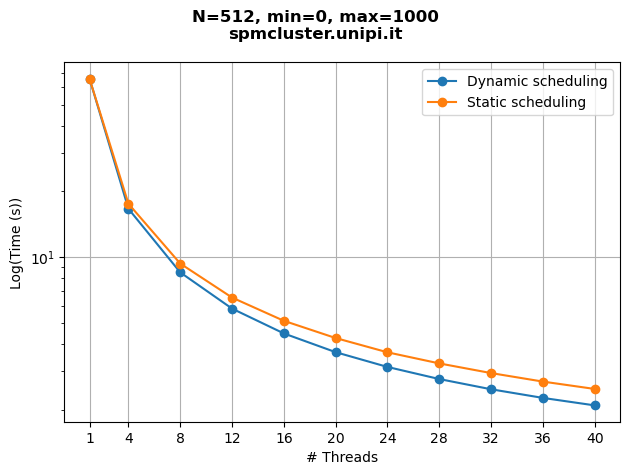

In [9]:
plt.semilogy(
    default_params_df["T"],
    default_params_df["pd_time_mean"],
    "-o",
    label="Dynamic scheduling"
)
plt.semilogy(
    default_params_df["T"],
    default_params_df["ps_time_mean"],
    "-o",
    label="Static scheduling"
)
plt.xticks(list(default_params_df["T"]))
plt.xlabel("# Threads")
plt.ylabel("Log(Time (s))")
plt.legend()
plt.grid()
plt.suptitle(
    f"N={DEFAULT_N}, min={DEFAULT_MIN}, max={DEFAULT_MAX}\n{MACHINE}",
    fontweight="bold"
)
plt.tight_layout()
plt.savefig(f"img/{MACHINE_TAG}_time_strong.png")

Plotting cost:

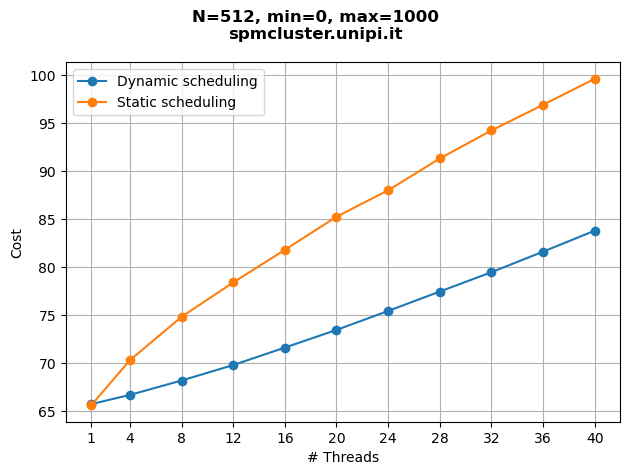

In [10]:
default_params_metrics_df.plot(
    kind="line",
    x="T",
    y=["pd_cost", "ps_cost"],
    style=["-o", "-o"],
    label=["Dynamic scheduling", "Static scheduling"]
)
plt.xticks(list(default_params_metrics_df["T"]))
plt.xlabel("# Threads")
plt.ylabel("Cost")
plt.legend()
plt.grid()
plt.suptitle(
    f"N={DEFAULT_N}, min={DEFAULT_MIN}, max={DEFAULT_MAX}\n{MACHINE}",
    fontweight="bold"
)
plt.tight_layout()
plt.savefig(f"img/{MACHINE_TAG}_cost_strong.png")

Plotting speedup:

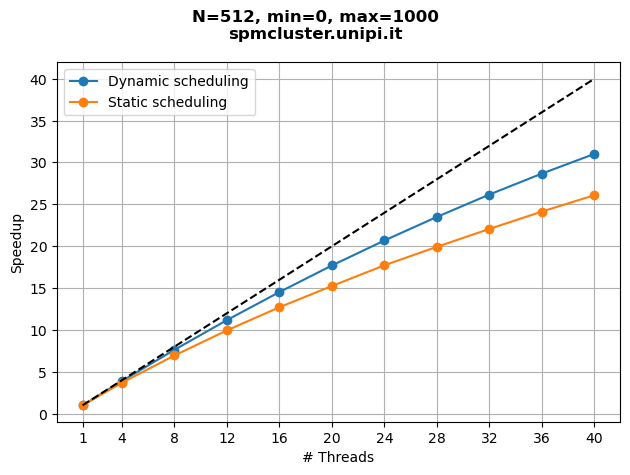

In [11]:
default_params_metrics_df.plot(
    kind="line",
    x="T",
    y=["pd_speedup", "ps_speedup"],
    style=["-o", "-o"],
    label=["Dynamic scheduling", "Static scheduling"]
)
plt.plot(
    default_params_metrics_df["T"],
    default_params_metrics_df["T"],
    "k--"
)
plt.xticks(list(default_params_metrics_df["T"]))
plt.xlabel("# Threads")
plt.ylabel("Speedup")
plt.legend()
plt.grid()
plt.suptitle(
    f"N={DEFAULT_N}, min={DEFAULT_MIN}, max={DEFAULT_MAX}\n{MACHINE}",
    fontweight="bold"
)
plt.tight_layout()
plt.savefig(f"img/{MACHINE_TAG}_speedup_strong.png")

Plotting scalability:

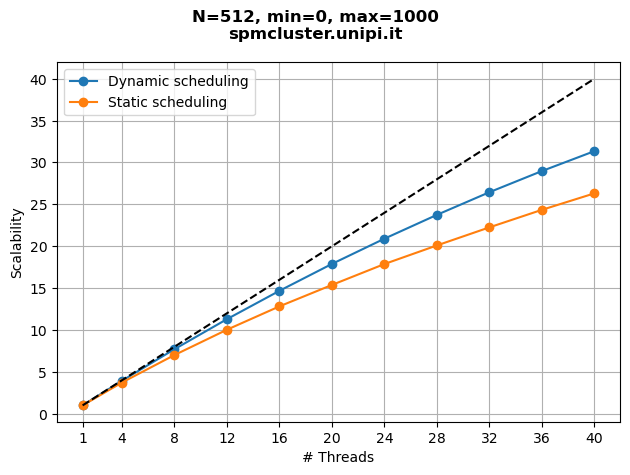

In [12]:
default_params_metrics_df.plot(
    kind="line",
    x="T",
    y=["pd_scalability", "ps_scalability"],
    style=["-o", "-o"],
    label=["Dynamic scheduling", "Static scheduling"]
)
plt.plot(
    default_params_metrics_df["T"],
    default_params_metrics_df["T"],
    "k--"
)
plt.xticks(list(default_params_metrics_df["T"]))
plt.xlabel("# Threads")
plt.ylabel("Scalability")
plt.legend()
plt.grid()
plt.suptitle(
    f"N={DEFAULT_N}, min={DEFAULT_MIN}, max={DEFAULT_MAX}\n{MACHINE}",
    fontweight="bold"
)
plt.tight_layout()
plt.savefig(f"img/{MACHINE_TAG}_scalability_strong.png")

Plotting efficiency:

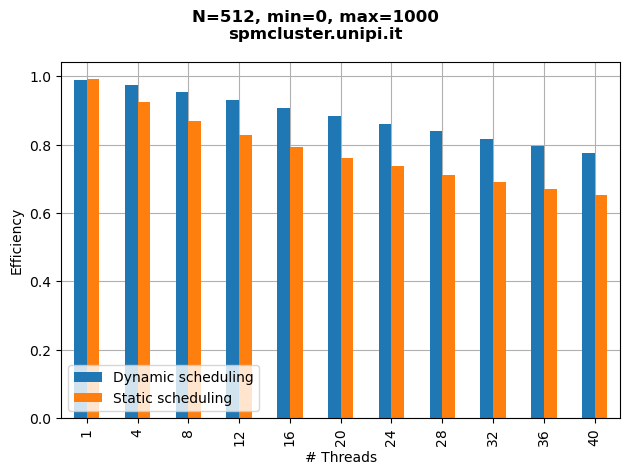

In [13]:
fig, axs = plt.subplots()
default_params_metrics_df.plot(
    kind="bar",
    x="T",
    y=["pd_efficiency", "ps_efficiency"],
    label=["Dynamic scheduling", "Static scheduling"],
    ax=axs
)
axs.set_xlabel("# Threads")
axs.set_ylabel("Efficiency")
axs.legend(loc='lower left')
axs.set_axisbelow(True)
axs.grid()
fig.suptitle(
    f"N={DEFAULT_N}, min={DEFAULT_MIN}, max={DEFAULT_MAX}\n{MACHINE}",
    fontweight="bold"
)
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_efficiency_strong.png")

## Weak scalability analysis

In [14]:
windows_df = data_grouped.loc[(slice(None), DEFAULT_N, slice(None), slice(None)), :]
windows_df.columns = ['_'.join(col).strip() for col in windows_df.columns.values]
windows_df = windows_df.rename(columns={"es_time_mean": "es_time"})
windows_df.reset_index(inplace=True)
maxs = [1000]+[t*1000 for t in range(4, NUM_CORES+1, 4)]
mins = [max-1000 for max in maxs]
windows_df = windows_df[(windows_df["max"].isin(maxs))&(windows_df["min"].isin(mins))]
windows_df

,T,N,min,max,es_time,as_time_mean,pd_time_mean,ps_time_mean
0,1,512,0,1000,65.0,-1.0,65.693057,65.562929
1,4,512,0,1000,65.0,-1.0,16.663514,17.567971
2,4,512,3000,4000,459.0,-1.0,115.661571,116.360571
3,8,512,0,1000,65.0,-1.0,8.519770,9.350060
4,8,512,7000,8000,984.0,-1.0,125.122250,125.745750
5,12,512,0,1000,65.0,-1.0,5.814322,6.532500
6,12,512,11000,12000,1510.0,-1.0,128.674714,129.306714
7,16,512,0,1000,65.0,-1.0,4.474739,5.112291
8,16,512,15000,16000,2035.0,-1.0,131.097000,131.684000
9,20,512,0,1000,65.0,-1.0,3.671979,4.262581


In [15]:
windows_df = windows_df[~((windows_df["T"]>1)&(windows_df["min"]==00))]
windows_df

,T,N,min,max,es_time,as_time_mean,pd_time_mean,ps_time_mean
0,1,512,0,1000,65.0,-1.0,65.693057,65.562929
2,4,512,3000,4000,459.0,-1.0,115.661571,116.360571
4,8,512,7000,8000,984.0,-1.0,125.122250,125.745750
6,12,512,11000,12000,1510.0,-1.0,128.674714,129.306714
8,16,512,15000,16000,2035.0,-1.0,131.097000,131.684000
10,20,512,19000,20000,2560.0,-1.0,132.993571,133.559714
12,24,512,23000,24000,3086.0,-1.0,134.605250,135.127000
14,28,512,27000,28000,3611.0,-1.0,136.056125,136.566125
16,32,512,31000,32000,4136.0,-1.0,137.328667,137.795000
18,36,512,35000,36000,4662.0,-1.0,138.684833,139.163500


In [16]:
windows_metrics_df = compute_metrics(windows_df)
windows_metrics_df

,T,pd_speedup,ps_speedup,pd_cost,ps_cost,pd_scalability,ps_scalability,pd_efficiency,ps_efficiency,ps_time_mean-pd_time_mean
0,1,0.989450,0.991414,65.693057,65.562929,1.000000,1.000000,0.989450,0.991414,-0.130129
2,4,3.968475,3.944635,462.646286,465.442286,0.567977,0.563446,0.992119,0.986159,0.699000
4,8,7.864309,7.825314,1000.978000,1005.966000,0.525031,0.521393,0.983039,0.978164,0.623500
6,12,11.735017,11.677661,1544.096571,1551.680571,0.510536,0.507034,0.977918,0.973138,0.632000
8,16,15.522857,15.453662,2097.552000,2106.944000,0.501103,0.497881,0.970179,0.965854,0.587000
10,20,19.249051,19.167456,2659.871429,2671.194286,0.493957,0.490889,0.962453,0.958373,0.566143
12,24,22.926297,22.837775,3230.526000,3243.048000,0.488042,0.485195,0.955262,0.951574,0.521750
14,28,26.540518,26.441403,3809.571500,3823.851500,0.482838,0.480082,0.947876,0.944336,0.510000
16,32,30.117528,30.015603,4394.517333,4409.440000,0.478364,0.475800,0.941173,0.937988,0.466333
18,36,33.615788,33.500163,4992.654000,5009.886000,0.473686,0.471122,0.933772,0.930560,0.478667


Plotting cost:

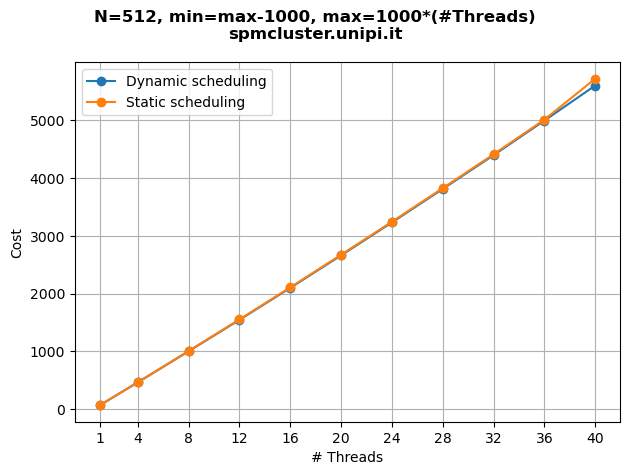

In [17]:
fig, axs = plt.subplots()
windows_metrics_df.plot(
    kind="line",
    x="T",
    y=["pd_cost", "ps_cost"],
    style=["-o", "-o"],
    label=["Dynamic scheduling", "Static scheduling"],
    ax=axs
)
axs.set_xticks(list(windows_metrics_df["T"]))
axs.set_xlabel("# Threads")
axs.set_ylabel("Cost")
axs.legend()
axs.grid()
fig.suptitle(
    f"N={DEFAULT_N}, min=max-1000, max=1000*(#Threads)\n{MACHINE}",
    fontweight="bold"
)
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_cost_weak.png")

Plotting speedup:

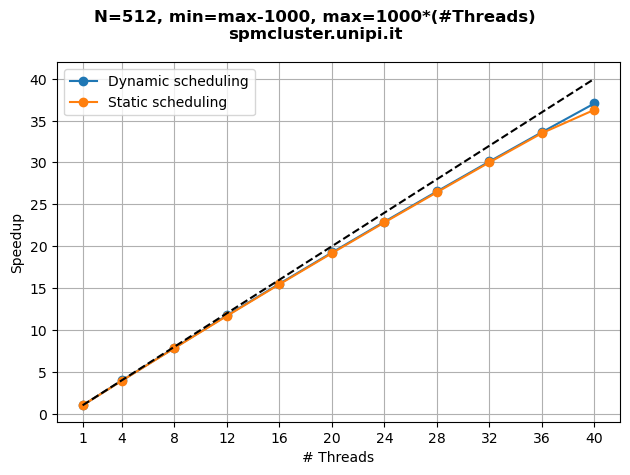

In [18]:
fig, axs = plt.subplots()
windows_metrics_df.plot(
    kind="line",
    x="T",
    y=["pd_speedup", "ps_speedup"],
    style=["-o", "-o"],
    label=["Dynamic scheduling", "Static scheduling"],
    ax=axs
)
axs.plot(
    windows_metrics_df["T"],
    windows_metrics_df["T"],
    "k--"
)
axs.set_xticks(list(windows_metrics_df["T"]))
axs.set_xlabel("# Threads")
axs.set_ylabel("Speedup")
axs.legend()
axs.grid()
fig.suptitle(
    f"N={DEFAULT_N}, min=max-1000, max=1000*(#Threads)\n{MACHINE}",
    fontweight="bold"
)
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_speedup_weak.png")

Plotting efficiency:

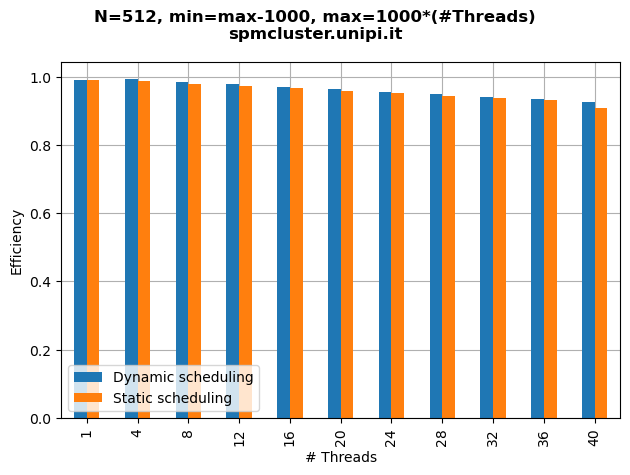

In [19]:
fig, axs = plt.subplots()
windows_metrics_df.plot(
    kind="bar",
    x="T",
    y=["pd_efficiency", "ps_efficiency"],
    label=["Dynamic scheduling", "Static scheduling"],
    ax=axs
)
axs.set_xlabel("# Threads")
axs.set_ylabel("Efficiency")
axs.legend(loc='lower left')
axs.set_axisbelow(True)
axs.grid()
fig.suptitle(
    f"N={DEFAULT_N}, min=max-1000, max=1000*(#Threads)\n{MACHINE}",
    fontweight="bold"
)
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_efficiency_weak.png")

## Comparison between strong and weak scalability

### Balanced setting

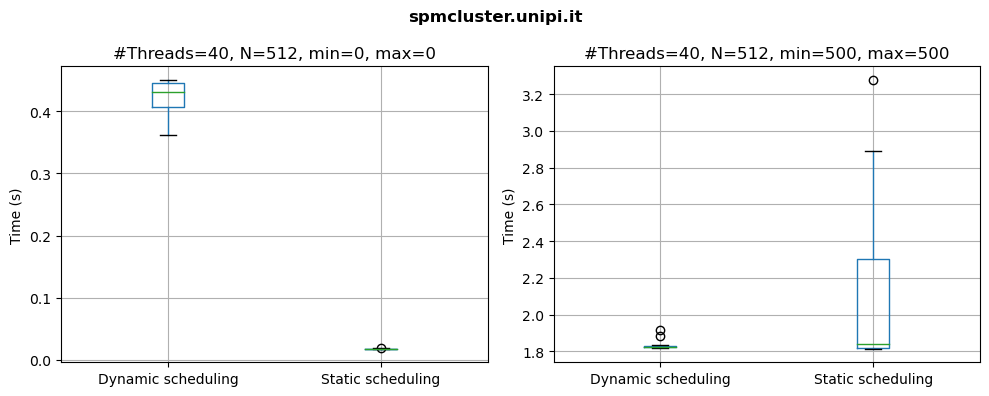

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
data[
    (data["T"]==NUM_CORES) &
    (data["N"]==DEFAULT_N) &
    (data["min"]==0) &
    (data["max"]==0)
    ].boxplot(column=["pd_time", "ps_time"], ax=axs[0])
axs[0].set_xticks([1, 2], ["Dynamic scheduling", "Static scheduling"])
axs[0].set_ylabel("Time (s)")
axs[0].set_title(f"#Threads={NUM_CORES}, N={DEFAULT_N}, min={0}, max={0}");

data[
    (data["T"]==NUM_CORES) &
    (data["N"]==DEFAULT_N) &
    (data["min"]==500) &
    (data["max"]==500)
    ].boxplot(column=["pd_time", "ps_time"], ax=axs[1])
axs[1].set_xticks([1, 2], ["Dynamic scheduling", "Static scheduling"])
axs[1].set_ylabel("Time (s)")
axs[1].set_title(f"#Threads={NUM_CORES}, N={DEFAULT_N}, min={500}, max={500}");
fig.suptitle(f"{MACHINE}", fontweight="bold")
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_boxplot_concurrency.png")

### Unbalanced setting

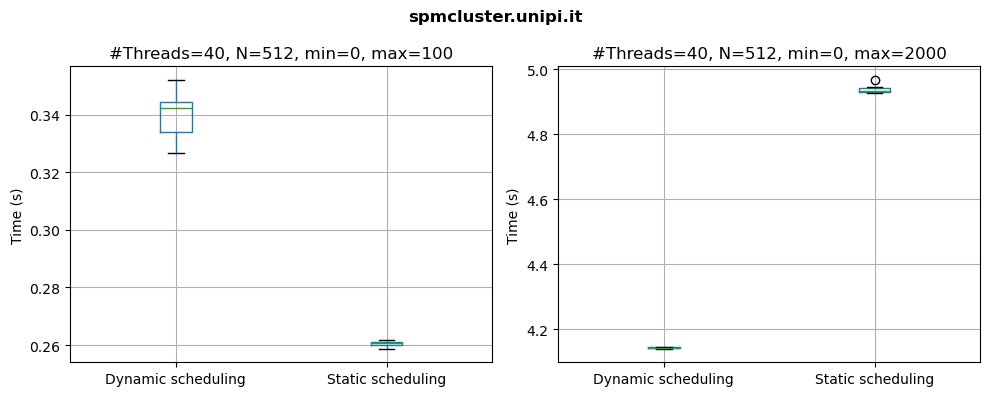

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
data[
    (data["T"]==NUM_CORES) &
    (data["N"]==DEFAULT_N) &
    (data["min"]==0) &
    (data["max"]==100)
    ].boxplot(column=["pd_time", "ps_time"], ax=axs[0])
axs[0].set_xticks([1, 2], ["Dynamic scheduling", "Static scheduling"])
axs[0].set_ylabel("Time (s)")
axs[0].set_title(f"#Threads={NUM_CORES}, N={DEFAULT_N}, min={0}, max={100}");
data[
    (data["T"]==NUM_CORES) &
    (data["N"]==DEFAULT_N) &
    (data["min"]==0) &
    (data["max"]==2000)
    ].boxplot(column=["pd_time", "ps_time"], ax=axs[1])
axs[1].set_xticks([1, 2], ["Dynamic scheduling", "Static scheduling"])
axs[1].set_ylabel("Time (s)")
axs[1].set_title(f"#Threads={NUM_CORES}, N={DEFAULT_N}, min={0}, max={2000}");
fig.suptitle(f"{MACHINE}", fontweight="bold")
fig.tight_layout()
fig.savefig(f"img/{MACHINE_TAG}_boxplot_unbalancing.png")